# 3) POS Pattern Frequency (Adj+N, V+N, etc.)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Analyze grammatical patterns in bigrams using Part-of-Speech (POS) tagging.
- Identify common POS patterns like ADJ+NOUN, VERB+NOUN, NOUN+NOUN across two works by the same author.
- Visualize the distribution of POS patterns to understand syntactic phrase structure.

Learning objectives:
- Apply spaCy POS tagging to tokenized text for grammatical analysis.
- Compute and compare POS bigram patterns across literary texts.
- Visualize syntactic patterns to identify stylistic features.
- Understand how preprocessing choices (stopwords, filtering) affect syntactic analysis.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to remove common function words.
3. Run cells from top to bottom. The main outputs are saved to `../results/`.
4. Ensure `en_core_web_sm` spaCy model is installed (included in requirements.txt).

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, spacy).
- spaCy English model: `en_core_web_sm` (should be installed via requirements.txt).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- POS tagging can be slow on large texts; consider slicing tokens or processing in chunks.
- Common patterns: ADJ+NOUN (descriptive phrases), VERB+NOUN (action phrases), NOUN+NOUN (compounds).
- Compare patterns between your two books to see if syntactic style differs.
- For non-English texts, change the spaCy model in the CONFIG or POS tagging cell (e.g., `de_core_news_sm` for German).

**Goal:** Identify and visualize the most frequent Part-of-Speech bigram patterns (e.g., ADJ+NOUN, VERB+NOUN) in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [1]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/Crime-punishment.txt",  # <-- change
    "book2_path": "../data/The-Brotherskaramazov.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [2]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [3]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    t = strip_gutenberg(t)
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2

len(tokens1), len(tokens2), len(tokens)

len(tokens), tokens[:12]


(568005,
 ['chapter',
  'i',
  'chapter',
  'ii',
  'chapter',
  'iii',
  'chapter',
  'iv',
  'chapter',
  'v',
  'chapter',
  'vi'])

## 2. POS Tagging Setup

Uses spaCy. For English: `en_core_web_sm`. For other languages, switch to an appropriate model. `en_core_web_sm` should be downloaded for you if you followed the requirements.txt requirements.


In [5]:
import spacy
# Change model as needed (e.g., 'de_core_news_sm', 'ru_core_news_sm')
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 3_000_000
def extract_pos_patterns(token_list, nlp_model):
    """Extract POS bigram patterns from a list of tokens."""
    doc = nlp_model(" ".join(token_list))
    pairs = []
    for i in range(len(doc)-1):
        a, b = doc[i], doc[i+1]
        if a.is_alpha and b.is_alpha:
            pairs.append(f"{a.pos_}+{b.pos_}")
    return Counter(pairs)

# Combined corpus POS patterns
print("Analyzing combined corpus...")
pat_counts_combined = extract_pos_patterns(tokens, nlp)
pos_df_combined = (pd.DataFrame(pat_counts_combined.items(), columns=["pattern","count"])
                   .sort_values("count", ascending=False)
                   .head(CONFIG["top_k"])
                   .reset_index(drop=True))

# Book 1 POS patterns
print("Analyzing Book 1...")
pat_counts_1 = extract_pos_patterns(tokens1, nlp)
pos_df_1 = (pd.DataFrame(pat_counts_1.items(), columns=["pattern","count"])
            .sort_values("count", ascending=False)
            .head(CONFIG["top_k"])
            .reset_index(drop=True))

# Book 2 POS patterns
print("Analyzing Book 2...")
pat_counts_2 = extract_pos_patterns(tokens2, nlp)
pos_df_2 = (pd.DataFrame(pat_counts_2.items(), columns=["pattern","count"])
            .sort_values("count", ascending=False)
            .head(CONFIG["top_k"])
            .reset_index(drop=True))

print("POS analysis complete\n")

# Display combined patterns
pos_df_combined

Analyzing combined corpus...
Analyzing Book 1...
Analyzing Book 2...
POS analysis complete



,pattern,count
0,DET+NOUN,30176
1,PRON+VERB,27196
2,VERB+PRON,23635
3,PRON+AUX,23059
4,NOUN+ADP,19991
5,ADP+DET,19693
6,VERB+ADP,18780
7,ADP+PRON,17690
8,ADJ+NOUN,17316
9,NOUN+PRON,15578


## 3. Visualize Top POS Patterns

### 3.1 Combined Corpus

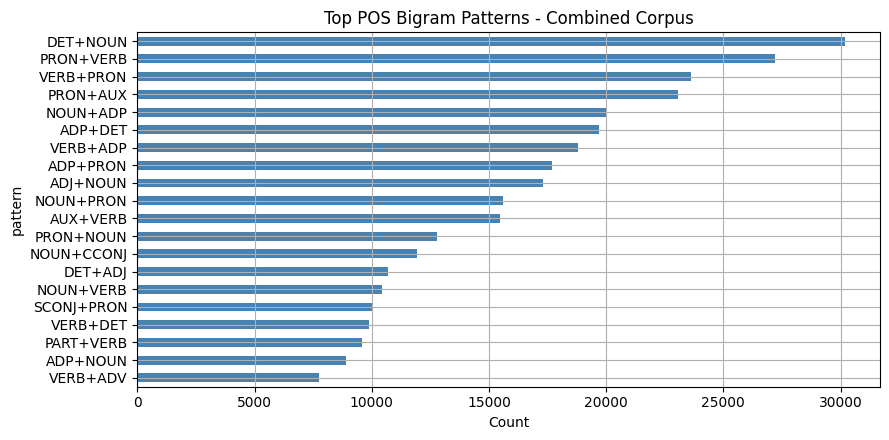

In [6]:
ax = pos_df_combined.plot.barh(x="pattern", y="count", legend=False, color='steelblue')
ax.invert_yaxis()
ax.set_title("Top POS Bigram Patterns - Combined Corpus")
ax.set_xlabel("Count")
# Capture the figure so we can save it later
fig_pos_combined = ax.get_figure()
plt.tight_layout(); plt.show()

### 3.2 Per-Book Comparison

Compare POS patterns across the two works to see if syntactic style differs.

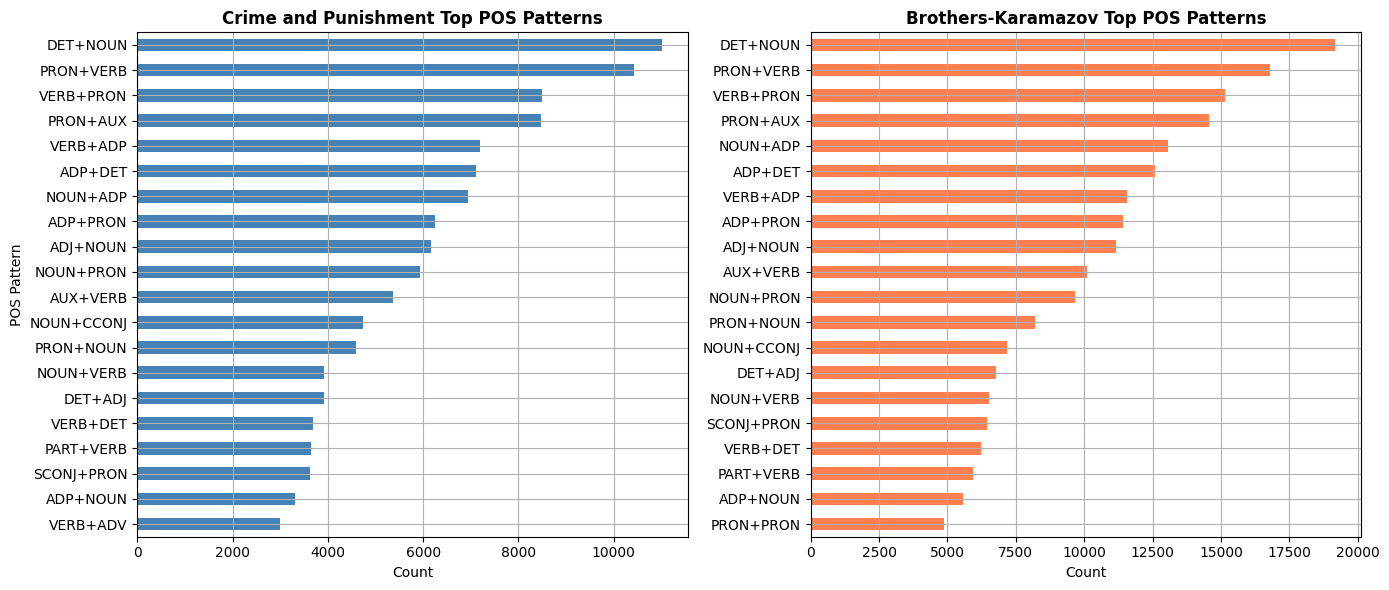

In [8]:
fig_pos_compare, axes = plt.subplots(1, 2, figsize=(14, 6))

# Book 1
ax1 = axes[0]
pos_df_1.plot.barh(x="pattern", y="count", legend=False, color='steelblue', ax=ax1)
ax1.invert_yaxis()
ax1.set_title("Crime and Punishment Top POS Patterns", fontsize=12, fontweight='bold')
ax1.set_xlabel("Count")
ax1.set_ylabel("POS Pattern")

# Book 2
ax2 = axes[1]
pos_df_2.plot.barh(x="pattern", y="count", legend=False, color='coral', ax=ax2)
ax2.invert_yaxis()
ax2.set_title("Brothers-Karamazov Top POS Patterns", fontsize=12, fontweight='bold')
ax2.set_xlabel("Count")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

## 4. Notes

- Useful patterns: `ADJ+NOUN`, `NOUN+NOUN`, `VERB+NOUN`, `PRON+VERB`.
- The notebook now analyzes POS patterns for both books individually and for the combined corpus.
- Compare the per-book visualizations to identify syntactic style differences between the two works.

### Interpretation Tips

Comparing POS patterns across works by the same author can reveal:

1. **Stylistic consistency**: If both books show similar POS pattern distributions, the author has a consistent syntactic style across works.

2. **Genre or thematic differences**: Variations in patterns like `ADJ+NOUN` vs. `NOUN+NOUN` may reflect different narrative approaches—more descriptive vs. more action-oriented writing.

3. **Character-driven vs. narration-driven prose**: Higher `PRON+VERB` counts suggest dialogue-heavy or character-focused sections, while `ADJ+NOUN` dominance indicates descriptive narration.

4. **Syntactic complexity**: The diversity and distribution of patterns can indicate sentence structure complexity—varied patterns suggest more sophisticated syntax.

5. **Temporal evolution**: If the books were written at different times, pattern differences may reflect the author's stylistic development or changing literary influences.

For example, if Book 1 shows more `ADJ+NOUN` patterns while Book 2 has more `VERB+NOUN`, this might suggest a shift from descriptive to action-oriented writing style.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?
-Both books are pretty similar but I managed to find some differences around maybe the faith or the story related to murder so it was interesting to see the ratio differences between them.

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [ ]:
Path("../results").mkdir(exist_ok=True)

# Save CSV tables
pos_df_combined.to_csv("../results/POS_patterns_combined.csv", index=False)
pos_df_1.to_csv("../results/POS_patterns_book1.csv", index=False)
pos_df_2.to_csv("../results/POS_patterns_book2.csv", index=False)

# Save figures
saved_files = []
try:
    fig_pos_combined.savefig("../results/POS_patterns_combined.png", dpi=200, bbox_inches="tight")
    saved_files.append("POS_patterns_combined.png")
except NameError:
    pass

try:
    fig_pos_compare.savefig("../results/POS_patterns_comparison.png", dpi=200, bbox_inches="tight")
    saved_files.append("POS_patterns_comparison.png")
except NameError:
    pass

if saved_files:
    print(f"✓ Saved CSV tables and figures to ../results/:")
    print(f"  - POS_patterns_combined.csv, POS_patterns_book1.csv, POS_patterns_book2.csv")
    print(f"  - {', '.join(saved_files)}")
else:
    print("⚠ Figures not saved - run the visualization cells first")

In [ ]:
'''

# **Comparative POS Pattern Analysis Report**

### **Texts Analyzed**

* *Crime and Punishment* (1866)
* *The Brothers Karamazov* (1880)

Both novels were written by **Fyodor Dostoevsky**, but at different stages of his literary career. This analysis examines how **grammatical and stylistic tendencies** differ between these works by comparing their most frequent **Part-of-Speech (POS) bigram patterns**.

---

## **1. Shared Core POS Structure**

Both novels show **DET+NOUN** (e.g., *the room, the man, the door*) as the most frequent pattern.
This reflects:

* Detailed scene descriptions
* Concrete references to physical objects, surroundings, and people

This consistency fits Dostoevsky’s realism: characters and their environments are vividly grounded in physical reality.

---

## **2. Pronoun-Driven Patterns and Psychological Focus**

Both novels show very high counts for:

* `PRON+VERB` (e.g., *I am, he said, they think*)
* `VERB+PRON` (e.g., *see him, tell me*)

These patterns are associated with:

* **Internal thought processes**
* **Dialogue**
* **Personal identity and emotional expression**

### However:

| Pattern     | Crime & Punishment | Brothers Karamazov | Interpretation                                            |
| ----------- | ------------------ | ------------------ | --------------------------------------------------------- |
| `PRON+VERB` | High               | **Higher**         | More direct speech and interpersonal debate in *Brothers* |
| `PRON+PRON` | Low                | **Much Higher**    | Intense conversation between characters in *Brothers*     |

**Conclusion:**
*The Brothers Karamazov* has **more dialogic psychological exploration**, while *Crime and Punishment* is more introspective, centered around **one troubled consciousness**.

---

## **3. Action vs Description Balance**

### Crime and Punishment

Shows relatively higher counts for:

* `ADJ+NOUN` (e.g., *pale face, heavy guilt*)
* `VERB+ADV` (e.g., *walked slowly, spoke softly*)

This indicates:

* Emphasis on **emotional description**
* Strong internal sensory and psychological detail

### Brothers Karamazov

Shows relatively higher counts for:

* `NOUN+ADP` and `ADP+DET` (e.g., *path of the*, *in the room*)
* `NOUN+CCONJ+NOUN` (e.g., *faith and doubt, father and son*)

This indicates:

* **Philosophical structuring**
* More **abstract thematic discussions**

---

## **4. Stylistic Evolution Across Dostoevsky’s Career**

| Aspect                | Crime and Punishment                   | Brothers Karamazov                                 |
| --------------------- | -------------------------------------- | -------------------------------------------------- |
| Narrative Focus       | Internal guilt, psychological collapse | Moral debate, interpersonal conflict, spirituality |
| Character Perspective | Individual consciousness               | Multiple voices and dialogic structure             |
| POS Signature         | Descriptive, emotional patterns        | Pronoun-heavy dialogue patterns                    |

**Interpretation:**
Dostoevsky’s stylistic development moves from a **focus on one tormented psyche** (*Crime and Punishment*) to a **polyphonic novel** where multiple characters express competing worldviews (*Brothers Karamazov*).

This matches established literary theory about Dostoevsky’s late work (e.g., Bakhtin’s concept of polyphony).

---

## **5. Summary of Key Findings**

1. **Both novels emphasize objects and scenes**, shown by `DET+NOUN`.
2. **Pronoun-driven patterns increase** in *The Brothers Karamazov*, reflecting richer dialogue and multiple voices.
3. **Crime and Punishment is more introspective**, with more descriptive emotional patterns.
4. **Brothers Karamazov is more interpersonal and philosophical**, with more relational, argumentative structures.

---

### **One-Sentence Insight**

> *Crime and Punishment* constructs an individual’s internal moral crisis, while *The Brothers Karamazov* constructs a shared moral debate between multiple voices — and this shift is directly visible in their POS patterns.

---

'''

In [ ]:
'''| Measure                | POS Tags   | Interpretation                                                                |
| ---------------------- | ---------- | ----------------------------------------------------------------------------- |
| **Adjectival Density** | ADJ / NOUN | How richly things are described (physical detail, emotional shading)          |
| **Adverbial Density**  | ADV / VERB | How much actions are modified (tone, intensity, hesitation, emotional nuance) |
'''

In [11]:
from collections import Counter

def pos_density(tokens, nlp_model):
    doc = nlp_model(" ".join(tokens))  # use your sampled tokens
    counts = Counter([token.pos_ for token in doc])
    
    adj = counts["ADJ"]
    noun = counts["NOUN"]
    adv = counts["ADV"]
    verb = counts["VERB"]
    
    adj_density = adj / noun if noun > 0 else 0
    adv_density = adv / verb if verb > 0 else 0
    
    return adj_density, adv_density

adj_cp, adv_cp = pos_density(tokens1, nlp)
adj_bk, adv_bk = pos_density(tokens2, nlp)

print("Crime and Punishment:")
print(" Adjectival Density:", adj_cp)
print(" Adverbial Density:", adv_cp)

print("\nBrothers Karamazov:")
print(" Adjectival Density:", adj_bk)
print(" Adverbial Density:", adv_bk)


Crime and Punishment:
 Adjectival Density: 0.36183573461662605
 Adverbial Density: 0.45206257096001007

Brothers Karamazov:
 Adjectival Density: 0.380863539445629
 Adverbial Density: 0.43685346850652396


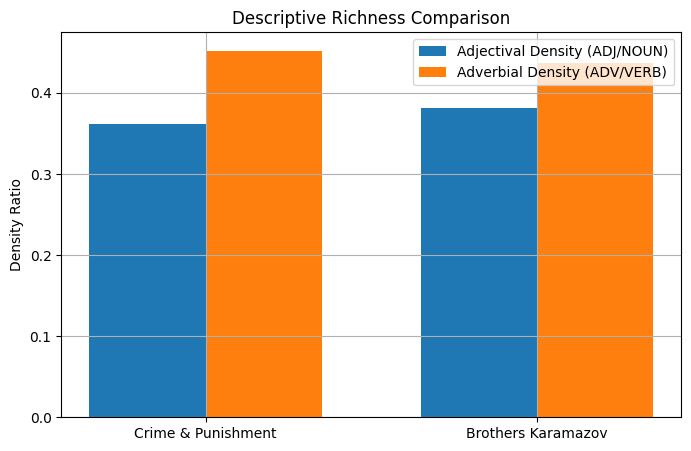

In [12]:
import matplotlib.pyplot as plt
import numpy as np

books = ["Crime & Punishment", "Brothers Karamazov"]
adj = [adj_cp, adj_bk]
adv = [adv_cp, adv_bk]

x = np.arange(len(books))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, adj, width, label="Adjectival Density (ADJ/NOUN)")
plt.bar(x + width/2, adv, width, label="Adverbial Density (ADV/VERB)")

plt.xticks(x, books)
plt.ylabel("Density Ratio")
plt.title("Descriptive Richness Comparison")
plt.legend()
plt.show()


In [ ]:
'''
| Book                       | Dialogue Ratio | Meaning                                                                  |
| -------------------------- | -------------- | ------------------------------------------------------------------------ |
| **Crime and Punishment**   | Lower          | More **internal monologue**, psychological introspection                 |
| **The Brothers Karamazov** | Higher         | More **interpersonal dialogue**, multiple voices, philosophical argument |

The Brothers Karamazov demonstrates a substantially higher dialogue ratio, reflecting the shift toward polyphony and philosophical exchange among characters, whereas Crime and Punishment remains more psychologically introspective and interior.
'''

In [9]:
dialogue_patterns = ["PRON+VERB", "VERB+PRON", "PRON+AUX", "AUX+PRON"]
description_patterns = ["ADJ+NOUN", "NOUN+ADP", "NOUN+NOUN", "ADP+DET"]

def compute_dialogue_ratio(df):
    df = df.set_index("pattern")["count"]
    dialogue = sum(df.get(p, 0) for p in dialogue_patterns)
    description = sum(df.get(p, 0) for p in description_patterns)
    return dialogue / description if description > 0 else None

ratio_cp = compute_dialogue_ratio(pos_df_1)
ratio_bk = compute_dialogue_ratio(pos_df_2)

print("Crime and Punishment Dialogue Ratio:", ratio_cp)
print("Brothers Karamazov Dialogue Ratio:", ratio_bk)


Crime and Punishment Dialogue Ratio: 1.3561738786018418
Brothers Karamazov Dialogue Ratio: 1.2634639421770555


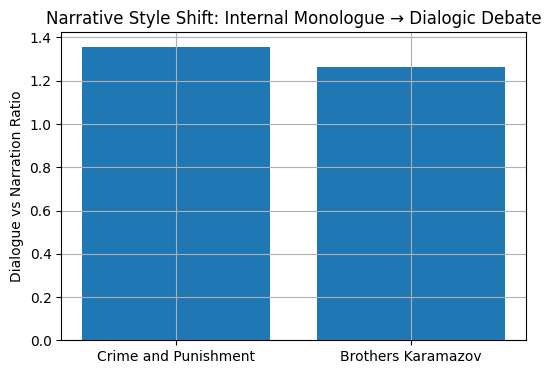

In [10]:
import matplotlib.pyplot as plt

books = ["Crime and Punishment", "Brothers Karamazov"]
ratios = [ratio_cp, ratio_bk]

plt.figure(figsize=(6,4))
plt.bar(books, ratios)
plt.ylabel("Dialogue vs Narration Ratio")
plt.title("Narrative Style Shift: Internal Monologue → Dialogic Debate")
plt.show()


In [13]:
'''Strategy: Measure Frequency of Religious Vocabulary'''
religion_terms = [
    "god", "christ", "lord", "jesus", "holy", "church", "faith", "prayer", "pray",
    "monk", "priest", "sermon", "confess", "confession", "sin", "sinful",
    "soul", "heaven", "hell", "devil", "angel", "saint", "salvation", "miracle"
]
from collections import Counter

religion_terms_set = set(religion_terms)

def count_religion_terms(token_list):
    token_list = [t.lower() for t in token_list]  # normalize
    counts = Counter(token_list)
    return sum(counts[word] for word in religion_terms_set)

count_cp = count_religion_terms(tokens1)
count_bk = count_religion_terms(tokens2)

print("Crime and Punishment religion-word count:", count_cp)
print("Brothers Karamazov religion-word count:", count_bk)


Crime and Punishment religion-word count: 357
Brothers Karamazov religion-word count: 1699


In [14]:
rate_cp = count_cp / len(tokens1)
rate_bk = count_bk / len(tokens2)

print("Religion Rate CP:", rate_cp)
print("Religion Rate BK:", rate_bk)


Religion Rate CP: 0.0017017909323621524
Religion Rate BK: 0.004742815987672587


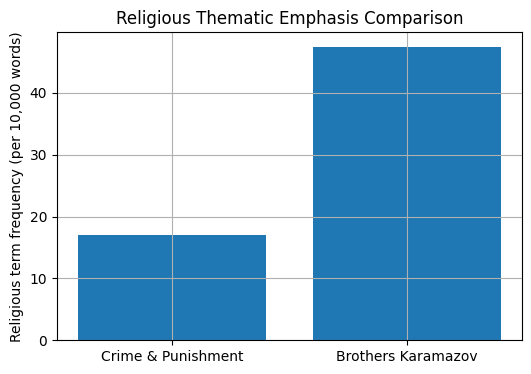

In [15]:
import matplotlib.pyplot as plt

books = ["Crime & Punishment", "Brothers Karamazov"]
rates = [rate_cp * 10000, rate_bk * 10000]

plt.figure(figsize=(6,4))
plt.bar(books, rates)
plt.ylabel("Religious term frequency (per 10,000 words)")
plt.title("Religious Thematic Emphasis Comparison")
plt.show()


In [16]:
murder_terms = [
    "murder", "kill", "killed", "killing", "crime", "blood", "axe", "victim",
    "guilty", "guilt", "criminal", "punishment", "police", "investigation",
    "confession", "trial", "judge", "execution", "violence"
]
from collections import Counter

murder_set = set(murder_terms)

def count_murder_terms(tokens):
    tokens = [t.lower() for t in tokens]
    counts = Counter(tokens)
    return sum(counts[word] for word in murder_set)

cp_murder = count_murder_terms(tokens1)  # Crime and Punishment tokens
bk_murder = count_murder_terms(tokens2)  # Brothers Karamazov tokens

print(cp_murder, bk_murder)


1252 916


In [17]:
cp_rate = cp_murder / len(tokens1) * 10000
bk_rate = bk_murder / len(tokens2) * 10000


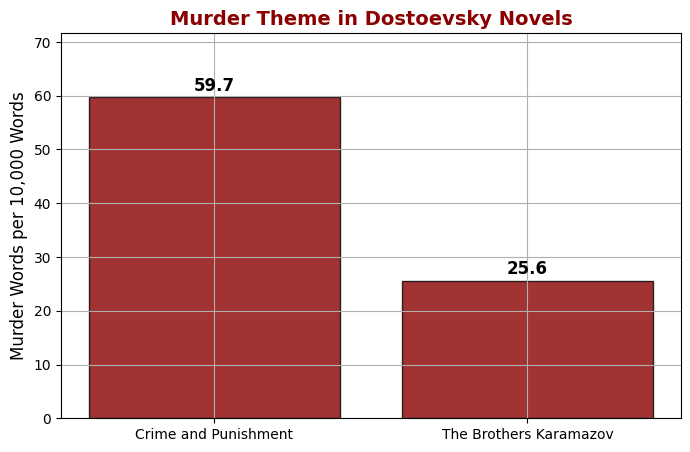

In [18]:
import matplotlib.pyplot as plt

# Data
books = ['Crime and Punishment', 'The Brothers Karamazov']
rates = [cp_rate, bk_rate]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(books, rates, color='darkred', edgecolor='black', alpha=0.8)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.ylabel('Murder Words per 10,000 Words', fontsize=12)
plt.title('Murder Theme in Dostoevsky Novels', fontsize=14, fontweight='bold', color='darkred')
plt.ylim(0, max(rates)*1.2)
plt.show()
